In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
path = 'C:\\Users\\Lenovo\\Desktop\\emin\\dataset\\aptos2019-blindness-detection\\'
df = pd.read_csv(path + 'train.csv', sep = ',')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


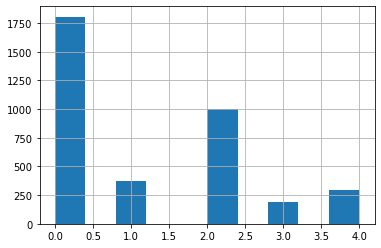

In [3]:
df['diagnosis'].hist()
print(df['diagnosis'].value_counts())

In [4]:
files = os.listdir(path + 'train_images')
print(len(files))

3662


In [5]:
img_list = []

from tqdm import tqdm_notebook as tqdm

for i in tqdm(files):
    image = cv2.imread(path + 'train_images\\' + i)
    image = cv2.resize(image, (400,400))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    kopya = image.copy()
    kopya = cv2.cvtColor(kopya, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(kopya, (5,5),0)
    thresh = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY)[1]
    kontur = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    kontur = kontur[0][0]
    kontur = kontur[:,0,:]
    x1 = tuple(kontur[kontur[:,0].argmin()])[0]                           
    y1 = tuple(kontur[kontur[:,1].argmin()])[1]
    x2 = tuple(kontur[kontur[:,0].argmax()])[0]
    y2 = tuple(kontur[kontur[:,1].argmax()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*5//50
    kopya2 = image.copy()                          
    if x2-x1 > 100 and y2-y1 > 100:
        kopya2 = kopya2[y1+y : y2-y, x1+x : x2-x]
        kopya2 = cv2.resize(kopya2,(400,400))
    lab = cv2.cvtColor(kopya2, cv2.COLOR_RGB2LAB)     
    l,a,b  = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=((8,8)))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))                          
    son = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    med_son = cv2.medianBlur(son, 3)
    arka_plan = cv2.medianBlur(son, 37)   
    maske = cv2.addWeighted(med_son, 1, arka_plan, -1, 255)
    son_img = cv2.bitwise_and(maske,med_son)
    img_list.append(son_img)
                              
                              
print(len(img_list))

<ipython-input-5-0ff81dce1bf8>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(files):


  0%|          | 0/3662 [00:00<?, ?it/s]

3662


In [ ]:
plt.imshow(img_list[1002])

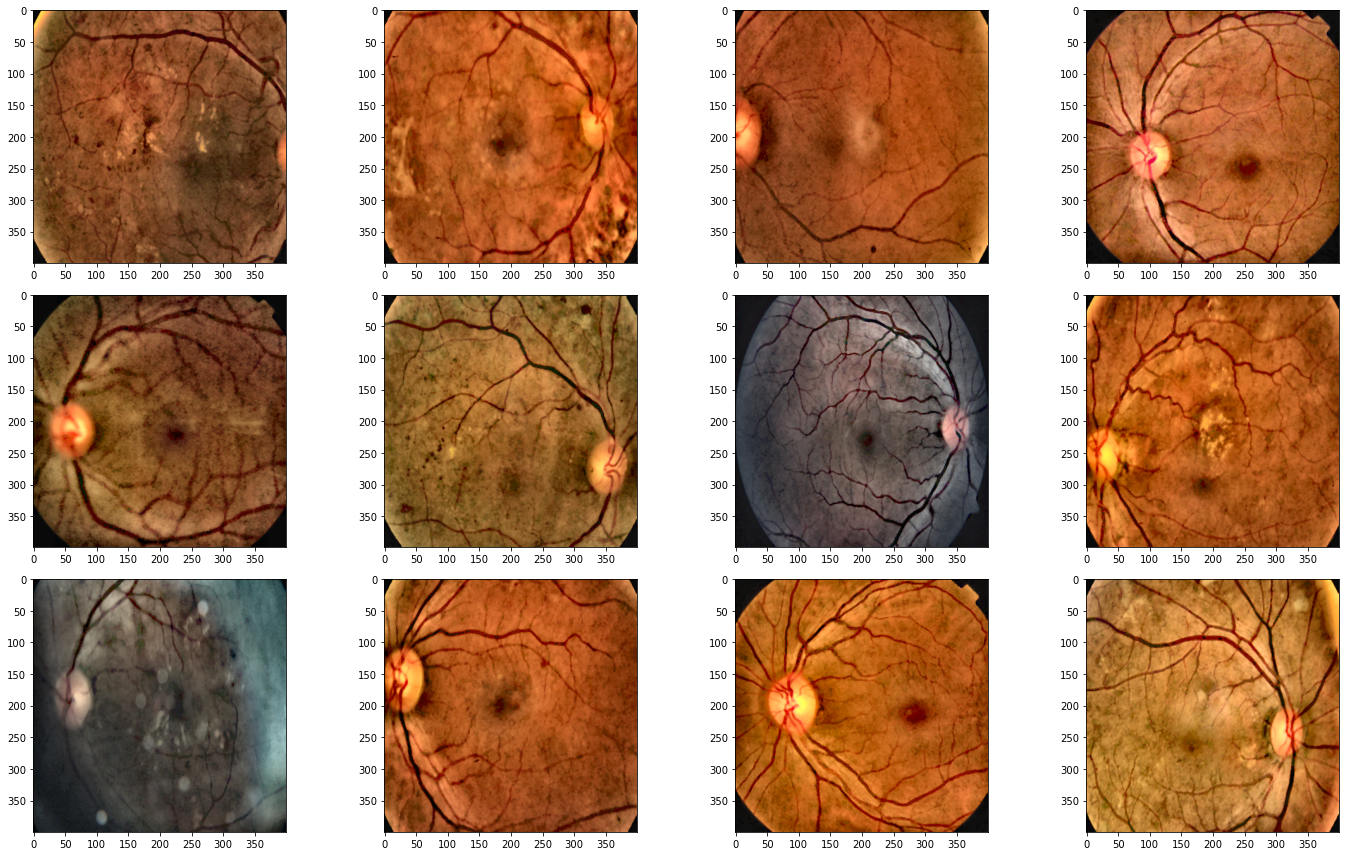

In [33]:
fig = plt.figure(figsize=(20,12))

for i in range(12):
    img = img_list[i]
    fig.add_subplot(3,4,i+1)
    plt.imshow(img)

plt.tight_layout()

In [34]:
y_train = pd.get_dummies(df['diagnosis']).values # onehotencoder

def control(cnt):
    cnt_ = int(cnt)
    print(f' Retinopati derecesi [{cnt_}] : ',df['diagnosis'][cnt_])
    print(f' Encoder Edilmis Retinopati derecesi [{cnt_}] : ',y_train[cnt_])

In [35]:
control(4)

 Retinopati derecesi [4] :  0
 Encoder Edilmis Retinopati derecesi [4] :  [1 0 0 0 0]


In [37]:
y_train_son = np.ones(y_train.shape, dtype='uint8')
print(y_train_son)

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 ...
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


In [38]:
y_train_son[:,4] = y_train[:,4]
print(y_train_son)

[[1 1 1 1 0]
 [1 1 1 1 1]
 [1 1 1 1 0]
 ...
 [1 1 1 1 0]
 [1 1 1 1 0]
 [1 1 1 1 0]]


In [39]:
print(np.logical_or(0,0))
print(np.logical_or(1,0))
print(np.logical_or(0,1))
print(np.logical_or(1,1))
#veya baglaci, ve baglaci icin logical_and

False
True
True
True


In [40]:
for a in range(3,-5,-1): # =1 kacin katini almak istedigini belirtiyor
    print(a)

3
2
1
0
-1
-2
-3
-4


In [41]:
for i in range(3,-1,-1):
    y_train_son[:,i] = np.logical_or(y_train[:,i], y_train_son[:,i+1])

In [42]:
y_train_son #son hali

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0]], dtype=uint8)

In [43]:
x_train = np.array(img_list)
print('X Train Shape:',x_train.shape)
print('Y Train Shape:',y_train.shape)

X Train Shape: (3662, 400, 400, 3)
Y Train Shape: (3662, 5)


In [44]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
                                                    x_train,
                                                    y_train,
                                                    test_size=0.15,
                                                    random_state=2019,
                                                    shuffle=True)

In [45]:
print('X Train Shape:',x_train.shape)
print('Y Train Shape:',y_train.shape)
print('X Test Shape:',x_val.shape)
print('Y Test Shape:',y_val.shape)

X Train Shape: (3112, 400, 400, 3)
Y Train Shape: (3112, 5)
X Test Shape: (550, 400, 400, 3)
Y Test Shape: (550, 5)


In [46]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True)
data_generator = datagen.flow(x_train,y_train,batch_size=2,seed=2020)

In [47]:
import tensorflow.keras.applications as apps
help(apps)

Help on package tensorflow.keras.applications in tensorflow.keras:

NAME
    tensorflow.keras.applications - Keras Applications are canned architectures with pre-trained weights.

PACKAGE CONTENTS
    densenet (package)
    efficientnet (package)
    imagenet_utils (package)
    inception_resnet_v2 (package)
    inception_v3 (package)
    mobilenet (package)
    mobilenet_v2 (package)
    nasnet (package)
    resnet (package)
    resnet50 (package)
    resnet_v2 (package)
    vgg16 (package)
    vgg19 (package)
    xception (package)

FILE
    c:\programdata\anaconda3\lib\site-packages\tensorflow\keras\applications\__init__.py




In [21]:
import tensorflow.keras.applications.efficientnet as apps

In [22]:
ornek_model = apps.EfficientNetB5()

In [23]:
ornek_model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 456, 456, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 456, 456, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 457, 457, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

__________________________________________________________________________________________________
block6g_se_expand (Conv2D)      (None, 1, 1, 1824)   140448      block6g_se_reduce[0][0]          
__________________________________________________________________________________________________
block6g_se_excite (Multiply)    (None, 15, 15, 1824) 0           block6g_activation[0][0]         
                                                                 block6g_se_expand[0][0]          
__________________________________________________________________________________________________
block6g_project_conv (Conv2D)   (None, 15, 15, 304)  554496      block6g_se_excite[0][0]          
__________________________________________________________________________________________________
block6g_project_bn (BatchNormal (None, 15, 15, 304)  1216        block6g_project_conv[0][0]       
__________________________________________________________________________________________________
block6g_dr

In [24]:
ornek_model = apps.EfficientNetB5(
    include_top=False
)
ornek_model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_____________________________________________________________________________________

block7c_se_excite (Multiply)    (None, None, None, 3 0           block7c_activation[0][0]         
                                                                 block7c_se_expand[0][0]          
__________________________________________________________________________________________________
block7c_project_conv (Conv2D)   (None, None, None, 5 1572864     block7c_se_excite[0][0]          
__________________________________________________________________________________________________
block7c_project_bn (BatchNormal (None, None, None, 5 2048        block7c_project_conv[0][0]       
__________________________________________________________________________________________________
block7c_drop (Dropout)          (None, None, None, 5 0           block7c_project_bn[0][0]         
__________________________________________________________________________________________________
block7c_add (Add)               (None, None, None, 5 0           block7c_drop[0][0]               
          

In [25]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(apps.EfficientNetB5(
    weights='imagenet',
    include_top=False,
    input_shape=(400,400,3)
))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='sigmoid'))

In [26]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00005), metrics=['accuracy'])

In [27]:
from keras.callbacks import ReduceLROnPlateau

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience = 3,
                       verbose=1,
                       mode='auto',
                       factor=0.25,
                       min_lr=0.000001) 

"""
patince : val_los degeri 3 kere ayni gelirse dusur
factor : surekli ayni degerleri vermeye basladiginda factor ile ogrenme katsayisi carpilir sonuc ise yeni lr olur
"""

'\npatince : val_los degeri 3 kere ayni gelirse dusur\nfactor : surekli ayni degerleri vermeye basladiginda factor ile ogrenme katsayisi carpilir sonuc ise yeni lr olur\n'

In [48]:
history = model.fit_generator(data_generator,
                             steps_per_epoch = 500, 
                              #epoch basi 100 tensor
                              # goruntu sayisi / data generator batch size
                              epochs = 8,
                              validation_data = (x_val, y_val),
                              callbacks=[lr]
                             )

Epoch 1/8


ResourceExhaustedError:  OOM when allocating tensor with shape[32,100,100,240] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node sequential/efficientnetb5/block2b_se_excite/mul (defined at <ipython-input-28-3a048da966c8>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_81979]

Function call stack:
train_function
